In [1]:
%matplotlib inline


Training a Classifier

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
import numpy as np


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation([-35, 35]),
     transforms.RandomHorizontalFlip(p=0.7),
     transforms.RandomVerticalFlip(p=0.6),
     transforms.Normalize(0.5, 0.5)])

trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=0)
print("Trainset size: ",len(trainset))

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

testset = torchvision.datasets.MNIST(root='./mnist_data', train=False,
                                       download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

print("Test size: ",len(testset))
classes = np.arange(0,10,1,dtype=int)

Trainset size:  60000
Test size:  10000


Let us show some of the training images, for fun.



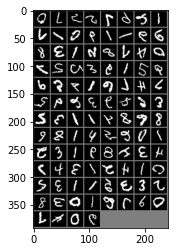

In [4]:
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))

## Using GPU to Training

In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3060


2. Define model



In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

ActF_List = [F.relu, F.leaky_relu, F.elu]
global act_Func_id
act_Func_id = 0  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=1)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes.size)
    def forward(self, x):
        x = self.pool(ActF_List[act_Func_id](self.conv1(x)))
        x = self.pool(ActF_List[act_Func_id](self.conv2(x)))
        x = torch.flatten(x, 1)
        x = ActF_List[act_Func_id](self.fc1(x))
        x = ActF_List[act_Func_id](self.fc2(x))
        x = self.fc3(x)
        return x
    
    
        
net = Net().to(device)
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
         MaxPool2d-2           [-1, 64, 12, 12]               0
            Conv2d-3          [-1, 128, 10, 10]         204,928
         MaxPool2d-4            [-1, 128, 5, 5]               0
            Linear-5                  [-1, 120]         384,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 601,726
Trainable params: 601,726
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 2.30
Estimated Total Size (MB): 2.77
----------------------------------------------------------------


3. Define a Loss function and optimizer



In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(net.parameters(), lr=1e-3, weight_decay=0.01)

In [8]:
def model_EvalAcc():
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    print('\nAccuracy of the network on the 10000 test images: %.2f %%' % (
        100 * correct / total))
    return correct / total

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
import time
# n_iters = 10000
# Epochs = n_iters / (len(trainset) / 100)
Epochs = 20
def model_fit(idx):
  
  global act_Func_id 
  act_Func_id = idx

  
  All_LossPerEpoch = np.empty(len(trainloader))
  Loss_History = np.empty(Epochs)
  
  print(f"Training use {str(ActF_List[idx])}\n")

  start_time = time.time()
  for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        All_LossPerEpoch[i] = loss.item()
        # print statistics
        if i == 0:
          print( f"\nEpoch:{epoch+1}" )
        print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end="" ,flush=True)
        Loss_History[epoch] = np.mean(All_LossPerEpoch)   
  Train_time = time.time() - start_time
  Accuracy = model_EvalAcc()
  print(f"\nFinished Training ,time cost: {Train_time}", end="\n")
  return Loss_History, (Train_time/60.0), Accuracy*100.0
  


Compare three activate_func

In [10]:
Compare_Items = ['Loss', 'TrainTime', 'Accuracy']
Loss_Compare = [[None] * Epochs] * 3
TrainTime_Compare = [None] * 3
Accuracy_Compare = [None] * 3
DifferenceDict = {'Loss': Loss_Compare,
                    'TrainTime': TrainTime_Compare,
                    'Accuracy': Accuracy_Compare}
model_list = ['./mnist_model/relu_model.pt', './mnist_model/leakyRelu_model.pt', './mnist_model/Elu_model.pt']
 
for act_func in ActF_List:
    actF_idx = ActF_List.index(act_func)
    Loss_Compare[actF_idx], TrainTime_Compare[actF_idx], Accuracy_Compare[actF_idx] = model_fit(actF_idx) 
    FILE = model_list[actF_idx]
    torch.save(net, FILE)    

Training use <function relu at 0x00000255A5BA31F8>


Epoch:1
	Batch:600 of 600, loss:0.619
Epoch:2
	Batch:600 of 600, loss:0.381
Epoch:3
	Batch:600 of 600, loss:0.278
Epoch:4
	Batch:600 of 600, loss:0.327
Epoch:5
	Batch:600 of 600, loss:0.240
Epoch:6
	Batch:600 of 600, loss:0.307
Epoch:7
	Batch:600 of 600, loss:0.306
Epoch:8
	Batch:600 of 600, loss:0.166
Epoch:9
	Batch:600 of 600, loss:0.187
Epoch:10
	Batch:600 of 600, loss:0.345
Epoch:11
	Batch:600 of 600, loss:0.161
Epoch:12
	Batch:600 of 600, loss:0.236
Epoch:13
	Batch:600 of 600, loss:0.242
Epoch:14
	Batch:600 of 600, loss:0.180
Epoch:15
	Batch:600 of 600, loss:0.203
Epoch:16
	Batch:600 of 600, loss:0.301
Epoch:17
	Batch:600 of 600, loss:0.230
Epoch:18
	Batch:600 of 600, loss:0.223
Epoch:19
	Batch:600 of 600, loss:0.188
Epoch:20
	Batch:600 of 600, loss:0.211
Accuracy of the network on the 10000 test images: 93.19 %

Finished Training ,time cost: 1138.3105008602142
Training use <function leaky_relu at 0x00000255A5BA35E8>


Epoch:1
	

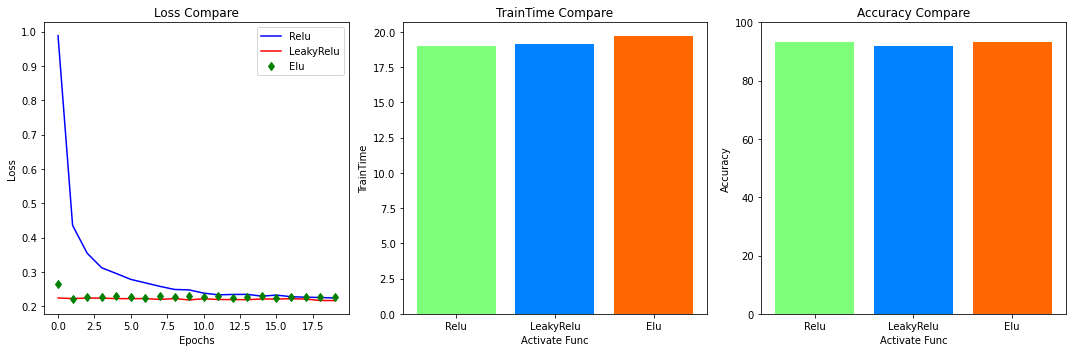

In [11]:
fig, ((LossFig, TrainTimeFig, AccFig)) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ActF_category = ['Relu', 'LeakyRelu', 'Elu']    

LossFig.plot(DifferenceDict['Loss'][0], 'b')
LossFig.plot(DifferenceDict['Loss'][1], 'r')
LossFig.plot(DifferenceDict['Loss'][2], 'gd')
LossFig.legend(['Relu','LeakyRelu','Elu'])
LossFig.set_title('Loss Compare')
LossFig.set_xlabel('Epochs')
LossFig.set_ylabel('Loss')

cmap = plt.get_cmap('jet')
color = [cmap(0.5), cmap(0.25), cmap(0.8)]
x = np.arange(1,4,dtype=int)

TrainTimeFig.bar(ActF_category, DifferenceDict['TrainTime'], color=color)
TrainTimeFig.set_title("TrainTime Compare")
TrainTimeFig.set_xlabel("Activate Func")
TrainTimeFig.set_ylabel("TrainTime")

AccFig.bar(ActF_category, DifferenceDict['Accuracy'], color=color) 
AccFig.set_ylim([0,100])
AccFig.set_title("Accuracy Compare")
AccFig.set_xlabel("Activate Func")
AccFig.set_ylabel("Accuracy")

fig.tight_layout()
plt.show()

In [12]:
print('=======================Performance Compare=======================')
print('Activation Func\t\tTraining Time(m)\tAccuracy')
for i in range(3):
    print(ActF_category[i], DifferenceDict['TrainTime'][i], DifferenceDict['Accuracy'][i], sep='\t\t')

=======================Performance Compare=======================
Activation Func		Training Time(m)	Accuracy
Relu		18.97184168100357		93.19
LeakyRelu		19.14183334906896		91.74
Elu		19.688966683546703		93.41000000000001


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

def model_performance(FILE):
    model = torch.load(FILE)
    
    total = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    preds = np.zeros((1))
    truth = np.zeros((1))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
            
    print('\nAccuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % ( classes[i], 100 * class_correct[i] / class_total[i]))
    
    # Display the confusion matrix as a heatmap
    arr = confusion_matrix(truth, preds)
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")

Display the confusion matrix as a heatmap

Some multi-class performance report defined from Scikit-learn